In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import datetime

<h1>Limpieza y filtrado de la data.<h1>

In [2]:
name = r"C:\Users\jibar\OneDrive - Universidad de los andes\Clases_Maestria\CIENCIA DE DATOS\Proyecto\General\General\Data\Daily.csv"

data =pd.read_csv(name,sep='|',error_bad_lines=False, warn_bad_lines= False,index_col=False,header=0, low_memory=False)

In [3]:
def eliminar_coma(x):
    x=str(x).replace(',','.')
    return x

In [4]:

data['VolUnCorrected']=data['VolUnCorrected'].apply(eliminar_coma)
data['VolCorrected']=data['VolCorrected'].apply(eliminar_coma)
data['Pressure']=data['Pressure'].apply(eliminar_coma)
data['Temperature']=data['Temperature'].apply(eliminar_coma)


convert = {'id_sitio':'object',
          'VolUnCorrected':float,
          'VolCorrected':float,
          'Pressure':float,
          'Temperature':float,
          'MaxPressure':float,
          'MinPressure':float,
          'MaxFlow':float,
          'MinFlow':float,
          'MaxTemp':float,
          'MinTemp':float,
          'id_RTU':'object'}
data = data.astype(convert)

In [5]:
selected = ['id_sitio','Daily_Date','VolUnCorrected',
       'VolCorrected', 'Pressure', 'Temperature']
data  = data[selected]

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [7]:
data['Daily_Date']   = pd.to_datetime(data['Daily_Date'])
data['Day'] =data['Daily_Date'].dt.date
lista = list(range(151,170))
data1 = data[data['id_sitio'].isin(lista)]

lista = [153, 154, 157, 160, 165, 167]
data1 = data[data['id_sitio'].isin(lista)]
grupo1 = data1.copy()

lista = [151, 152, 155, 156, 158, 159, 161, 162, 163, 164, 166, 168, 169, 170]
data1 = data[data['id_sitio'].isin(lista)]
grupo2 = data1.copy()

<h1> Etiquetado<h1>

In [8]:
grupo2

,id_sitio,Daily_Date,VolUnCorrected,VolCorrected,Pressure,Temperature,Day
127,151,2013-08-22 23:59:59,1228.00,20478.64,231.00,27.00,2013-08-22
128,152,2013-08-22 23:59:59,981.00,16091.16,227.00,27.00,2013-08-22
131,155,2013-08-22 23:59:59,1056.01,17570.78,230.00,26.00,2013-08-22
132,156,2013-08-22 23:59:59,791.93,13256.85,233.00,26.00,2013-08-22
134,158,2013-08-22 23:59:59,1091.98,17638.21,224.00,27.00,2013-08-22
...,...,...,...,...,...,...,...
396767,161,2018-01-22 23:59:59,2581.70,43405.62,191.15,9.58,2018-01-22
396768,162,2018-01-22 23:59:59,1295.42,21777.57,117.72,12.23,2018-01-22
396769,163,2018-01-22 23:59:59,1102.33,18881.58,118.55,12.31,2018-01-22
396770,164,2018-01-22 23:59:59,2068.11,33963.35,114.95,13.32,2018-01-22


In [9]:
mapa = grupo2['id_sitio']==151
inst = grupo2[mapa].copy()
day = inst['Day']
daily =inst['Daily_Date'] 
inst.drop(['id_sitio','Day'],axis = 1,inplace = True)
scaler = StandardScaler()
stan = scaler.fit_transform(inst.drop(['Daily_Date'], axis = 1))

datframe = pd.DataFrame(data=stan,columns=inst.drop(['Daily_Date'],axis = 1).columns)
datframe['Daily_Date'] = daily.reset_index(drop=True)

datframe.sort_values(by='Daily_Date',inplace = True)
datframe.reset_index(inplace=True,drop=True)



<h3> datos superiores a 2 std</h3>

In [10]:
datframe['Mayor_2std'] = (datframe['VolUnCorrected']>2) | (datframe['VolUnCorrected']<-2)

<h3>Datos que tiene 3 datos consecutivos anteriores o posteriores</h3>

In [11]:

consecutivos = 3
lista =[]


for i in range(0,datframe.index.max()+1):
    if i<3:
        adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        lista.append(adelante)
    elif i>datframe.index.max()-3:
        atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        lista.append(atras)
    else :
        atras = (datframe['VolUnCorrected'].iloc[i-consecutivos:i].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        adelante = (datframe['VolUnCorrected'].iloc[i:i+consecutivos].mean()==datframe['VolUnCorrected'].iloc[i].mean())
        consecutivo= atras | adelante
        lista.append(consecutivo)
datframe['Consecutivo']=lista


<h3> Determinacion de Falla<h3>

In [12]:
datframe['Falla']=(datframe['Mayor_2std'] & datframe['Consecutivo'])


<h3>Ventana prediccion</h3>

In [19]:
lista = []
ventana =10
for i in range(0,datframe.index.max()+1):
    if datframe.index.max()-(ventana-1)>i:
        lista.append(datframe['Falla'].iloc[i:i+ventana].any())
    else :
        lista.append(False)
datframe['Predictor']=lista


<h3> Solo elementos ants de la falla<h3>

In [20]:
datframe['SoloAntes']=(datframe['Falla'] ^ datframe['Predictor'])


In [25]:
datframe['FallaNum'] = datframe['Falla'].map({True:3,False:0})
datframe['PredictorNum'] = datframe['Predictor'].map({True:2,False:0})
datframe['SoloAntesNum'] = datframe['SoloAntes'].map({True:1,False:0})

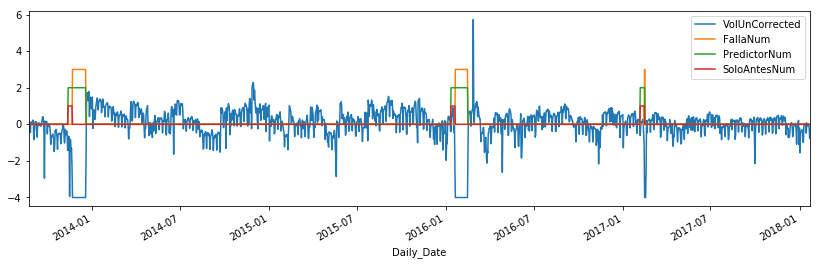

In [26]:
datframe.set_index(keys='Daily_Date')[['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))

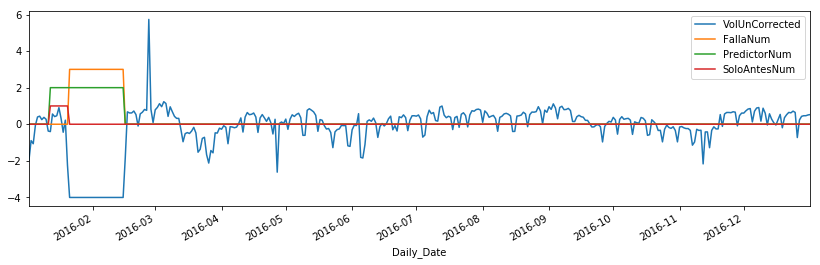

In [28]:
fecha ='2016'
fig=datframe.set_index(keys='Daily_Date')[fecha][['VolUnCorrected','FallaNum', 'PredictorNum','SoloAntesNum']].plot(figsize = (14,4))
